# Full-waveform inversion (FWI) with automated adjoint and checkpointing

Full-waveform inversion (FWI) is a technique in general employed to estimate the physical parameters in a subsurface region. It is a wave-equation-based seeking an optimal match between observed and computed data. The former is recorded by receivers in a real case. The latter consists of a computed data, which is obtained by solving numerically a wave equation with an forcing term representing a source of wave emission. 

## Functional to be minimised
A tradicional form to measure the difference between the observed and computed data is given by the functional (Tarantola, 1984): 
$$
    I(u, u^{obs}) = \sum_{r=0}^{N-1} \int_\Omega \left(u(c,\mathbf{x},t)- u^{obs}(c, \mathbf{x},t)\right)^2 \delta(x - x_r) \, dx
$$
where $u = u(c, \mathbf{x},t)$ and $u_{obs} = u_{obs}(c,\mathbf{x},t)$, are respectively the computed and observed data, both recorded at a finite number of receivers ($N_r$), located at the point positions $\check{\mathbf{x}} \in \Omega_{0}$, in a time interval $\tau\equiv[t_0, t_f]\subset \mathbb{R}$, where $t_0$ is the initial time and $t_f$ is the final time. The spatial domain of interest is set as $\Omega_{0}$.

An FWI problem consists in finding an optimal parameter $c$ that minimizes the functional $I(u, u^{obs})$.

## Wave equation
To have the computed data, we need first solve a wave equation. In this example, we consider the scalar acoustic wave equation using a damping term to attenate the reflections originated by the boundaries of the domain.
$$
    \frac{\partial^2 u}{\partial t^2}(\mathbf{x},t)- c^2\frac{\partial^2 u}{\partial \mathbf{x}^2} = f(\mathbf{x}_s,t) \tag{2}
$$
where $c(\mathbf{x}):\Omega_{0}\rightarrow \mathbb{R}$ is the pressure wave velocity, which is assumed here a piecewise-constant and positive. The source term $f(\mathbf{x}_s,t)$ represents a point of wave source.
The wave equation (2) satisfies the boundary conditions:
$$
    u(\mathbf{x},t) = 0, \quad \mathbf{x} \in \partial\Omega_{0}, \quad t\in\tau
$$
The acoustic wave equation should satisfy the initial conditions $u(\mathbf{x}, 0)  = 0 = u_t(\mathbf{x}, 0) = 0$.

To solve the wave equation, we consider the following weak form over the domain $\Omega_{0}$:
$$
    \int_{\Omega_{0}} \left(\frac{\partial^2 u}{\partial t^2}v + c^2\nabla u \cdot \nabla v\right) \, dx = \int_{\Omega_{0}} f v \, dx,
$$
for an arbitrary test function $v\in V$, where $V$ is a function space. The implementation of the weak form is given by the following Firedrake code:

In [23]:
import finat
import os
import warnings
warnings.filterwarnings("ignore")
from firedrake import *


def wave_equation_solver(c, source_function, dt, V):
    """Solves the acoustic wave equation in 2D.

    Parameters
    ----------
    c : velocity field
        The velocity field.
    source_function : firedrake.Function
        The function that models the source of the wave.
    dt : float
        The time step.
    V : firedrake.FunctionSpace
        The function space where the solution lives.

    Returns
    -------
    firedrake.LinearVariationalSolver, firedrake.Function, firedrake.Function, firedrake.Function
        Return the linear variational solver and the functions for the solution at time `n+1`, `n` and `n-1`.
        These outputs are going to be used in a time loop.
    
    Notes
    -----
    Additional information about this wave equation solver, including the discretisation and the
    linear variational problem, please refer this 
    `documentation link <https://www.firedrakeproject.org/demos/higher_order_mass_lumping.py.html>`_.
    """
    u = TrialFunction(V)
    v = TestFunction(V)

    u_np1 = Function(V) # timestep n+1
    u_n = Function(V) # timestep n
    u_nm1 = Function(V) # timestep n-1

    # quadrature rule for lumped mass matrix
    quad_rule = finat.quadrature.make_quadrature(V.finat_element.cell, V.ufl_element().degree(), "KMV")
    m =  (u - 2.0 * u_n + u_nm1) / Constant(dt * dt) * v * dx(scheme=quad_rule)
    nf = c * ((u_n - u_nm1) / dt) * v * ds
    a = c * c * dot(grad(u_n), grad(v)) * dx
    F = m + a + nf - source_function * v * dx(scheme=quad_rule)
    lhs_ = lhs(F)
    rhs_ = rhs(F)
    lin_var = LinearVariationalProblem(lhs_, rhs_, u_np1)
    solver = LinearVariationalSolver(lin_var, solver_parameters={"ksp_type": "preonly", "pc_type": "jacobi"})
    return solver, u_np1, u_n, u_nm1

The wave euqation forcing $f = f(\mathbf{x}_s, t)$ represents a time-dependent wave source locate at the position $\mathbf{x}_s$, being written of the form:
$$
    f(\mathbf{x}_s,t) = r(t) \delta(\mathbf{x} - \mathbf{x}_s)
$$
where $r(t)$ is the [Ricker wavelet](https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet), and $\delta(\mathbf{x} - \mathbf{x}_s)$ is the Dirac delta function. This forcing term is implemented in Firedrake as follows:

In [24]:
import numpy as np
from firedrake.__future__ import interpolate, Interpolator
from firedrake.pyplot import tricontourf, tripcolor
import matplotlib.pyplot as plt
def forcing(parent_mesh, delta_loc, mesh, W):
    vom_mesh = VertexOnlyMesh(mesh, [delta_loc])
    vom_space = FunctionSpace(vom_mesh, "DG", 0)
    forcing_point = assemble(Constant(1.0)*TestFunction(vom_space)*dx)
    interp = Interpolator(TestFunction(W), vom_space) # noqa: E501
    # f = assemble(interp.interpolate(forcing_point, transpose=True))
    return interp, forcing_point

The implementation of [Ricker wavelet](https://wiki.seg.org/wiki/Dictionary:Ricker_wavelet) is given by the following Firedrake code:

In [25]:
def ricker_wavelet(t, fs, amp=1.0):
    """Ricker wavelet.

    Parameters
    ----------
    t : float
        Time.
    fs : float
        Frequency.
    amp : float, optional
        Amplitude of the wavelet.

    Returns
    -------
    float
        The value of the wavelet at time `t`.
    """
    ts = 1.5
    t0 = t - ts * np.sqrt(6.0) / (np.pi * fs)
    rw = (amp * (1.0 - (1.0 / 2.0) * (2.0 * np.pi * fs) * (2.0 * np.pi * fs) * t0 * t0)
            * np.exp(
                (-1.0 / 4.0) * (2.0 * np.pi * fs) * (2.0 * np.pi * fs) * t0 * t0
            )
        )
    return rw

## FWI execution
In this example, we consider a two dimensional domain where we want to estimate the parameter $c$ in a physical domain with the lenght of $1$ km ($L_x = 1km$) and the depth of $1$ km ($L_z = 1km$).

Below we create a dictionary containing the parameters necessary to solve the wave equation. The `model` dictionary contains the keys containing the basic setup to execute the acoust wave equation, and the FWI.

In addition, we create a `plot_function` used to plot the solutions and the parameter $c$ in the nexts code cells.

In [26]:
%matplotlib inline
from firedrake.pyplot import tricontourf
import matplotlib.pyplot as plt
Lx, Lz = 1, 1
num_receivers = 10
num_sources = 3
model = {
    "source_locations": np.linspace((0.2, 0.1), (0.8, 0.1), num_sources),
    "receiver_locations": np.linspace((0.1, 0.1), (0.9, 0.1), num_receivers),
    "mesh": UnitSquareMesh(60, 60),
    "dt": 0.002,  # time step
    "final_time": 0.2,  # final time
    "functional": None,  # The functional to be used in the inversion. Must be a callable.
    "syntetic_receiver_data": None,  # The syntetic receiver data to be used in the inversion.
    "frequency_peak": 7.0,  # The dominant frequency of the source.
}

def plot_function(function):
    # NBVAL_IGNORE_OUTPUT
    fig, axes = plt.subplots()
    contours = tricontourf(function, 10, axes=axes)
    fig.colorbar(contours, ax=axes, fraction=0.01, cmap="seismic")
    plt.gca().invert_yaxis()
    axes.set_aspect("equal")
    

As we mentioed before, an FWI problem consists in finding an optimal parameter $c$ that minimises the functional $I(u, u^{obs})$, where $u^{obs}$ is the observed data. In this example, we consider this observed data as a synthetic data, which is obtained by solving the wave equation with a known parameter $c_{true}$. For the sake of simplicity, we consider the velocity model consisting of a circle in the center of the domain as shown in the next code cell.

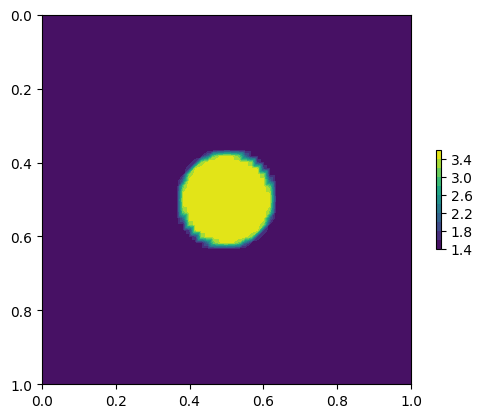

In [27]:
V = FunctionSpace(model["mesh"], "KMV", 1)
x, z = SpatialCoordinate(model["mesh"])
c_true = Function(V).interpolate(2.5 + 1 * tanh(200 * (0.125 - sqrt((x - 0.5) ** 2 + (z - 0.5) ** 2))))
plot_function(c_true)

Next, we get the synthetic data recorded on the receivers by executing the wave equation with the true syntetic $c_{true}$.

In [28]:
def true_receiver_data(syntetic_pressure, receiver_locations, receiver_mesh, sn=0):
    """Compute the syntetic receiver data.

    Parameters
    ----------
    syntetic_pressure : Function
        The syntetic pressure field.
    receiver_locations : array_like
        The receiver locations.
    receiver_mesh : firedrake.VertexOnlyMesh
        The receiver mesh.
    sn : int, optional
        The source number.

    Returns
    -------
    list
        The syntetic receiver data for all time steps.
    """
    V = FunctionSpace(model["mesh"], "KMV", 1)
    source_function = Function(V)
    solver, u_np1, u_n, u_nm1 = wave_equation_solver(c_true, source_function, model["dt"], V)
    interpolator_sources, forcing_point = forcing(model["mesh"], model["source_locations"][sn], model["mesh"], V)
    P0DG = FunctionSpace(receiver_mesh, "DG", 0)
    interpolator_receivers = Interpolator(u_np1, P0DG)
    u_sol_receivers = []
    for t in np.arange(0, model["final_time"], model["dt"]):
        forcing_point.dat.data[:] = ricker_wavelet(t, model["frequency_peak"])
        source_function.assign(assemble(interpolator_sources.interpolate(forcing_point, transpose=True)
                                        ).riesz_representation(riesz_map="l2"))
        # Call the solver object.
        solver.solve()
        # Update the solution at the previous time steps.
        u_nm1.assign(u_n)
        u_n.assign(u_np1)
        # Interpolate the solution at the receiver locations and store the result.
        # This data will be used in the inversion to compute the functional.
        u_sol_receivers.append(assemble(interpolator_receivers.interpolate()))
    plot_function(u_np1)
    return u_sol_receivers

receiver_mesh =  VertexOnlyMesh(model["mesh"], model["receiver_locations"])
u_sol_sources = []
num_sources = model["source_locations"].shape[0]
for sn in range(num_sources):
    print(f"Computing syntetic receiver data for source {sn+1} of {num_sources}")
    u_sol_sources.append(true_receiver_data(c_true, model["receiver_locations"], receiver_mesh, sn))

Computing syntetic receiver data for source 1 of 3


TypeError: Sparsity._process_args() got an unexpected keyword argument 'iteration_regions'

Before starting the FWI, we implement the functional $I(u, u^{obs})$....

In [ ]:
def functional(u, true_receiver_data):
    """Compute the functional."""
    P0DG = FunctionSpace(receiver_mesh, "DG", 0)
    guess_receiver = assemble(interpolate(u, P0DG))
    return 0.5 * assemble(inner(guess_receiver - true_receiver_data, guess_receiver - true_receiver_data) * dx)

model["functional"] = functional


We now seeks to run a FWI problem, which involves the following steps:
1. Set the initial guess for the parameter $c$;
2. Solve the wave equation with the initial guess for the parameter $c$;
3. Compute the functional $I(u, u^{obs})$;
4. Compute the gradient of the functional $I(u, u^{obs})$ with respect to the parameter $c$;
5. Update the parameter $c$ using a gradient-based optimization method;

The gradient is computed automatically using the algorithmic differentiation (AD) pyadjoint. To have the automated gradient computation, we need to tape the forward solver associate to the paremeter $c$, which minimises the functional $I(u, u^{obs})$. Taping the forward solver starts when we set `continue_annotation()`.

In [ ]:
from firedrake.adjoint import continue_annotation
continue_annotation()

True

FWI is now to require extensive memory usage. To mitigate this issue, we can use the checkpointing technique. An FWI solver in firedrake is enabled to use the checkpointing technique by setting:
```python
    tape = get_working_tape()
    tape.enable_checkpointing(schedule)
```
where `schedule` is a checkpointing schedule.

The code cell below shows the definition of the checkpointing schedule and the command to enable the checkpointing technique.

<div class="alert alert-block alert-info">
<b>Note:</b> If you do not want to use checkpointing in your FWI, you can skip the cell below.
</div>

In [ ]:
from checkpoint_schedules import Revolve
from firedrake.adjoint import get_working_tape
total_steps = int(model["final_time"] / model["dt"])
print(f"Total steps: {total_steps}")
tape = get_working_tape()
tape.clear_tape()
tape.enable_checkpointing(Revolve(total_steps -1, 7))

Total steps: 400


The code cell below is forward solver for the guess parameter $c_{guess}$. This foward solver will ve taped by the algorithmic differentiation to compute the gradient of the functional $I(u, u^{obs})$.

In [ ]:
def J(c, true_receiver_data, sn):
    V = FunctionSpace(model["mesh"], model["element_model"]["method"], model["element_model"]["degree"])
    source_function = Function(V)
    solver, u_np1, u_n, u_nm1 = wave_equation_solver(c, source_function, model["dt"], V)
    interpolator, forcing_point = forcing(model["mesh"], model["source_locations"][sn], model["mesh"], V)
    J_val = 0.0
    for t in tape.timestepper(iter(range(int(model["final_time"] / model["dt"])))):
        forcing_point.dat.data[:] = ricker_wavelet(t, model["frequency_peak"])
        source_function.assign(assemble(interpolator.interpolate(forcing_point, transpose=True)
                                        ).riesz_representation(riesz_map='L2'))
        solver.solve()
        u_nm1.assign(u_n)
        u_n.assign(u_np1)
        # functional must be callable.
        functional = model["functional"]
        J_val += functional(u_n, true_receiver_data[t])
    return J_val

Running source 1 of 3
Running source 2 of 3
Running source 3 of 3
Running source 1 of 3RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3721     M =           10

At X0      3721 variables are exactly at the bounds

At iterate    0    f=  1.27647D+00    |proj g|=  1.41514D-08

Running source 2 of 3
Running source 3 of 3

At iterate    1    f=  1.27647D+00    |proj g|=  1.41514D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3721      1      2      1     0  1587   1.415D-08   1.276D+00
  F =   1.2764664077644823     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


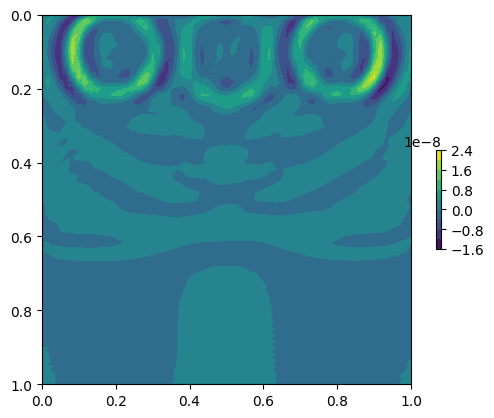

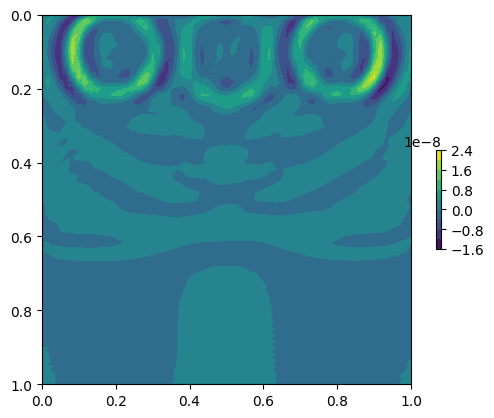

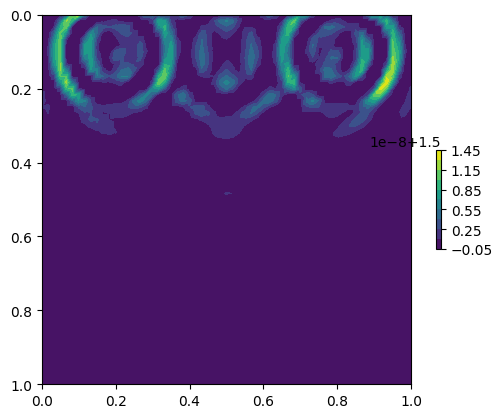

In [ ]:
tape.clear_tape()
from scipy.optimize import minimize as scipy_minimize
from firedrake.adjoint import compute_gradient, Control
def run_fwi(vp_guess_data):
    J_total = 0.0
    dJ_total = Function(V)
    vp_guess = Function(V)
    vp_guess.dat.data[:] = vp_guess_data
    num_sources = len(model["source_locations"])
    for sn in range(num_sources):
        print(f"Running source {sn + 1} of {len(model['source_locations'])}")
        J_s = J(vp_guess, u_sol_sources[sn], sn)
        dJ_total += compute_gradient(J_s, Control(vp_guess))
        J_total += J_s
    # why the gradient magnitude is so small?
    plot_function(dJ_total)
    get_working_tape().clear_tape()
    return J_total, dJ_total.dat.data[:]

c = Function(V).interpolate(1.5)
bounds = [(1.5, 3.5)] * len(c.dat.data)
result_data = scipy_minimize(run_fwi, c.dat.data[:], method='L-BFGS-B',
                             jac=True, tol=1e-15, bounds=bounds,
                             options={"disp": True, "eps": 1e-15,
                                      "gtol": 1e-15, "maxiter": 1})
vp_end = Function(V)
vp_end.dat.data[:] = result_data.x
plot_function(vp_end)